In [1]:
import os
import datetime

import pandas as pd
import numpy as np
np.random.seed(42)
import matplotlib.pyplot as plt
from matplotlib import dates as mdates

from coropy.growth_models import GrowthCOVIDModel
import plotting
plotting.configure()

b_d = plotting.default_colors('blue')
r_d = plotting.default_colors('red')

In [2]:
# all data
DATA_DIR = 'data'
FILE_NAME = 'initial_timeseries_SEIRD.csv' 
FILE_PATH = os.path.join(os.pardir, DATA_DIR, FILE_NAME)
df = pd.read_csv(FILE_PATH)

# derived data
cum_positives = np.cumsum(df.confirmed_positives.values)
cum_recovered = df.estimate_recovered.values
cum_deceased = np.cumsum(df.confirmed_deceased.values)
active = cum_positives - cum_recovered - cum_deceased

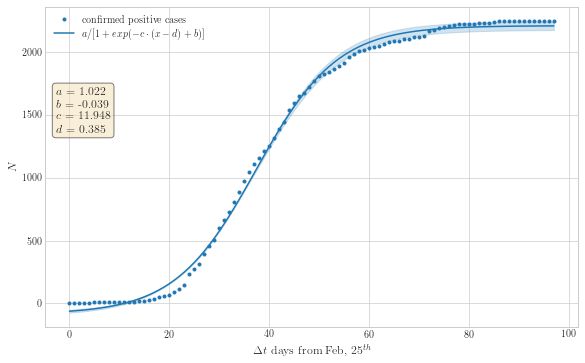

In [3]:
# fit the entire first wave data to a logistic model
model = GrowthCOVIDModel('logistic', normalize=True, calc_ci=True)
model.fit(cum_positives)
x, fitted = model.get_fitted
a, b, c, d = model.get_params

# visualize
fig = plt.figure()
ax = fig.subplots(nrows=1, ncols=1)
ax.plot(x, cum_positives, '.', color=b_d, label='confirmed positive cases')
ax.plot(x, fitted[1], '-', color=b_d, label=r'$a / [1 + exp (-c \cdot (x - d) + b )]$')
ax.fill_between(x, fitted[0], fitted[2], color=b_d, alpha=0.2)
ax.text(0.02, 0.75,
        f'$a$ = {round(a, 3)}\n$b$ = {round(b, 3)}\n$c$ = {round(c, 3)}\n$d$ = {round(d, 3)}',
        verticalalignment='top', transform=ax.transAxes,
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
ax.set_xlabel(r'$\Delta t$ days from Feb, $25^{th}$')
ax.set_ylabel(r'$N$')
ax.legend()
plt.show()
fname = f'cumulative_positives-sigmoidal_fit'
fig.savefig(fname=os.path.join('output', 'figs', fname + '.pdf'), format='pdf', bbox_inches='tight')

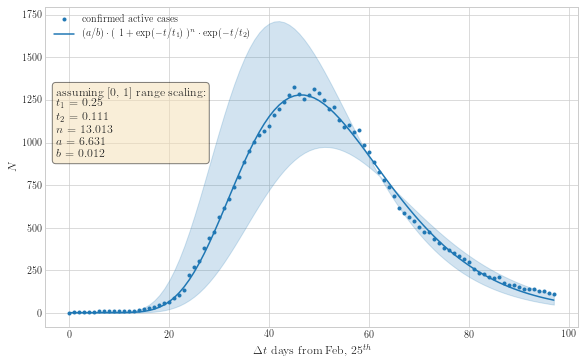

In [16]:
# fit the entire first wave data to a Heidler function
def heidler(t, t1, t2, n, a, b):
    exp_1 = 1 - np.exp(-t/t1)
    exp_2 = np.exp(-t/t2)
    # if np.sign is not used NumPy will generate RuntimeWarning: invalid value encountered in power
    # https://stackoverflow.com/questions/45384602/numpy-runtimewarning-invalid-value-encountered-in-power#45384691
    return a/b * np.sign(exp_1) * (np.abs(exp_1))**n * exp_2  

model = GrowthCOVIDModel(heidler, normalize=True, calc_ci=True)
model.fit(active)
x, fitted = model.get_fitted
t1, t2, n, a, b = model.get_params

# visualize
fig = plt.figure()
ax = fig.subplots(nrows=1, ncols=1)
ax.plot(x, active, '.', color=b_d, label='confirmed active cases')
ax.plot(x, fitted[1], '-', color=b_d, label=r'$(a/b) \cdot (~1+\exp(-t/t_1)~)^n \cdot \exp(-t/t_2)$')
ax.fill_between(x, fitted[0], fitted[2], color=b_d, alpha=0.2)
ax.text(0.02, 0.75, f'assuming [0, 1] range scaling:\n$t_1$ = {round(t1, 3)}\n$t_2$ = {round(t2, 3)}\n$n$ = {round(n, 3)}\n$a$ = {round(a, 3)}\n$b$ = {round(b, 3)}', verticalalignment='top', transform=ax.transAxes,  bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
ax.set_xlabel(r'$\Delta t$ days from Feb, $25^{th}$')
ax.set_ylabel(r'$N$')
ax.legend(loc='upper left')
plt.show()
fname = f'active_positives-heidler_fit'
fig.savefig(fname=os.path.join('output', 'figs', fname + '.pdf'), format='pdf', bbox_inches='tight')

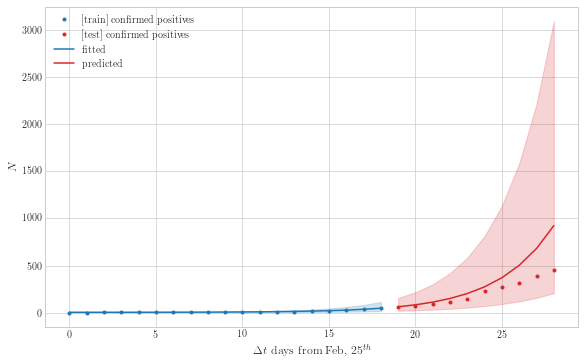

In [17]:
start_date = datetime.datetime(2020, 2, 25)
end_critical = datetime.datetime(2020, 3, 15)
dur_critical = (end_critical - start_date).days
n_days_future = 10
y_train, y_test = cum_positives[:dur_critical], cum_positives[dur_critical:dur_critical+n_days_future]

# fit the critical initial period to model and evaulate the extrapolation performance
model = GrowthCOVIDModel('exponential', normalize=True, calc_ci=True)
model.fit(y_train)
x_fit, y_fit = model.get_fitted
x_pred, y_pred = model.predict(n_days_future)

# visualize
fig = plt.figure()
ax = fig.subplots(nrows=1, ncols=1)
ax.plot(x_fit, y_train, '.', color=b_d, label='[train] confirmed positives')
ax.plot(x_pred, y_test, '.', color=r_d, label='[test] confirmed positives')
ax.plot(x_fit, y_fit[1], '-', color=b_d, label='fitted')
ax.fill_between(x_fit, y_fit[0], y_fit[2], color=b_d, alpha=0.2)
ax.plot(x_pred, y_pred[1], '-', color=r_d, label='predicted')
ax.fill_between(x_pred, y_pred[0], y_pred[2], color=r_d, alpha=0.2)
ax.set_xlabel(r'$\Delta t$ days from Feb, $25^{th}$')
ax.set_ylabel(r'$N$')
ax.legend(loc='upper left')
plt.show()
fname = f'cumulative_positives-exponential_fit-{n_days_future}_days_extrapolation'
fig.savefig(fname=os.path.join('output', 'figs', fname + '.pdf'), format='pdf', bbox_inches='tight')